In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import params
import data_loader

In [2]:
x_train_ori, y_train_ori, x_test_ori, y_test_ori = data_loader.get_train_test()

Load .edf -> .\data\PSGData1_Hang7\20190917-T3-93135.edf
Extracting EDF parameters from E:\ZJU_Research\SR_ZJUPH_PSG\data\PSGData1_Hang7\20190917-T3-93135.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


E:\ZJU_Research\SR_ZJUPH_PSG\utils.py:27: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo
  raw_train = mne.io.read_raw_edf(path)


1186 36441088
Normalizing ... Current Dimension -> 0
Normalizing ... Current Dimension -> 1
Normalizing ... Current Dimension -> 2
Normalizing ... Current Dimension -> 3
Normalizing ... Current Dimension -> 4
Normalizing ... Current Dimension -> 5
Normalizing ... Current Dimension -> 6
Normalizing ... Current Dimension -> 7
Normalizing ... Current Dimension -> 8
Normalizing ... Current Dimension -> 9
Normalizing ... Current Dimension -> 10
Normalizing ... Current Dimension -> 11
Normalizing ... Current Dimension -> 12
Normalizing ... Current Dimension -> 13
Normalizing ... Current Dimension -> 14
Normalizing ... Current Dimension -> 15
Normalizing ... Current Dimension -> 16
Normalizing ... Current Dimension -> 17
Normalizing ... Current Dimension -> 18
Normalizing ... Current Dimension -> 19
Normalizing ... Current Dimension -> 20
Return data, np.std(data) is too Low! len data -> 36441088
Normalizing ... Current Dimension -> 21
Normalizing ... Current Dimension -> 22
Return data, np.s

E:\ZJU_Research\SR_ZJUPH_PSG\utils.py:27: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo
  raw_train = mne.io.read_raw_edf(path)


1168 35885056
Normalizing ... Current Dimension -> 0
Normalizing ... Current Dimension -> 1
Normalizing ... Current Dimension -> 2
Normalizing ... Current Dimension -> 3
Normalizing ... Current Dimension -> 4
Normalizing ... Current Dimension -> 5
Normalizing ... Current Dimension -> 6
Normalizing ... Current Dimension -> 7
Normalizing ... Current Dimension -> 8
Normalizing ... Current Dimension -> 9
Normalizing ... Current Dimension -> 10
Normalizing ... Current Dimension -> 11
Normalizing ... Current Dimension -> 12
Normalizing ... Current Dimension -> 13
Normalizing ... Current Dimension -> 14
Normalizing ... Current Dimension -> 15
Normalizing ... Current Dimension -> 16
Normalizing ... Current Dimension -> 17
Normalizing ... Current Dimension -> 18
Normalizing ... Current Dimension -> 19
Normalizing ... Current Dimension -> 20
Normalizing ... Current Dimension -> 21
Normalizing ... Current Dimension -> 22
Normalization Done!
Generating Train&Test ... Current Index -> 0
Generating 

In [3]:
!pip install visualkeras

You should consider upgrading via the 'D:\Miniconda3\envs\tf\python.exe -m pip install --upgrade pip' command.


In [4]:
!conda install -c conda-forge ann -y
!conda install -c conda-forge ann_visualizer -y
!conda install graphviz -y
!conda install -c anaconda python-graphviz -y
!conda install -c anaconda pydot -y

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Miniconda3\envs\tf

  added / updated specs:
    - ann


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2022.4.26-h~ --> conda-forge::ca-certificates-2022.5.18.1-h5b45459_0
  certifi            anaconda::certifi-2021.10.8-py39haa95~ --> conda-forge::certifi-2022.5.18.1-py39hcbf5309_0

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl              pkgs/main::openssl-1.1.1o-h2bbff1b_0 --> conda-forge::openssl-1.1.1o-h8ffe710_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Rolling back transaction: ...working... done


ERROR conda.core.link:_execute(730): An error occurred while installing package 'conda-forge::openssl-1.1.1o-h8ffe710_0'.

[Errno 13] Permission denied: 'D:\\Miniconda3\\envs\\tf\\Library\\bin\\libssl-1_1-x64.dll'
()



Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Miniconda3\envs\tf

  added / updated specs:
    - ann_visualizer


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2022.4.26-h~ --> conda-forge::ca-certificates-2022.5.18.1-h5b45459_0
  certifi            anaconda::certifi-2021.10.8-py39haa95~ --> conda-forge::certifi-2022.5.18.1-py39hcbf5309_0

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl              pkgs/main::openssl-1.1.1o-h2bbff1b_0 --> conda-forge::openssl-1.1.1o-h8ffe710_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Miniconda3\envs\tf

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ----------------------

In [24]:
from models import cnn_1, cnn_2, cnn_lstm, cnn_crf, resnet_101v2, efficient_net_v2l, vgg_19
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from glob import glob
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from ann_visualizer.visualize import ann_viz
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import tensorboard
from tensorflow.keras.utils import to_categorical
import datetime
from tensorflow.keras.utils import plot_model
import visualkeras

In [6]:
x_train, y_train, x_test, y_test = x_train_ori, to_categorical(y_train_ori, params.NUM_CLASS), x_test_ori, to_categorical(y_test_ori, params.NUM_CLASS)

In [7]:
data_loader.show_shape(x_train, y_train, x_test, y_test)

x_train -> (188, 30726, 23) (30726, 23)
y_train -> (188, 5)
x_test  -> (47, 30726, 23) (30726, 23)
y_test  -> (47, 5)


In [58]:
MODEL_LIST = []

In [60]:
MODEL_LIST.append(cnn_1())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30726, 23)]       0         
                                                                 
 conv1d_46 (Conv1D)          (None, 30726, 16)         1856      
                                                                 
 conv1d_47 (Conv1D)          (None, 30726, 16)         1296      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 15363, 16)        0         
 g1D)                                                            
                                                                 
 spatial_dropout1d_19 (Spati  (None, 15363, 16)        0         
 alDropout1D)                                                    
                                                                 
 conv1d_48 (Conv1D)          (None, 15363, 32)         1568

In [61]:
NAME_LIST = ["cnn_1"]

In [62]:
HIST_LIST, TRAINED_MODEL = [], []

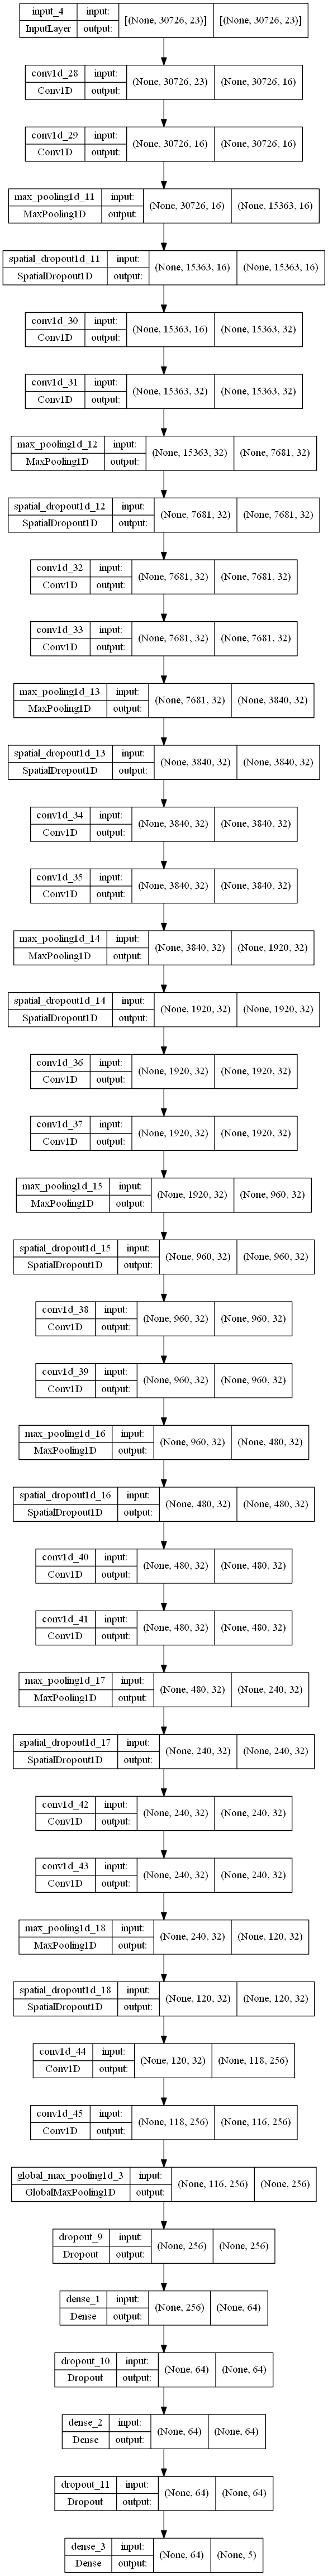

In [63]:
plot_model(MODEL_LIST[0], to_file="./images/" + NAME_LIST[0] + ".png", show_shapes=True, show_layer_names=True)

In [64]:
DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [65]:
def get_callbacks(file_path, model_name):
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=20, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, verbose=2)
    log_dir = "logs/" + str(model_name) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tfboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks_list = [checkpoint, early, redonplat, tfboard]

In [66]:
def train_model(model, name):
    file_path = './models/' + name + "_" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + '.h5'
    callbacks_list = get_callbacks(file_path, name)
    opt = Adam(learning_rate=params.LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(x=x_train, y=y_train,
                        epochs=params.EPOCH_NUM,
                        batch_size=params.BATCH_SIZE,
                        validation_data=(x_test, y_test),
                        verbose=params.VERBOSE,
                        callbacks=callbacks_list)
#     model.save(file_path)
#     model = load_model(file_path)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Loss: ', test_loss)
    print('Accuracy: ', test_acc) 
    return history, model

In [67]:
for i in range(len(MODEL_LIST)):
    history, trained_model = train_model(MODEL_LIST[i], NAME_LIST[i])
    HIST_LIST.append(history)
    TRAINED_MODEL.append(trained_model)

Epoch 1/100
6/6 [==============================] - 3s 244ms/step - loss: 2.0737 - accuracy: 0.3511 - val_loss: 1.5577 - val_accuracy: 0.4255
Epoch 2/100
6/6 [==============================] - 1s 108ms/step - loss: 1.5694 - accuracy: 0.3830 - val_loss: 1.5280 - val_accuracy: 0.4255
Epoch 3/100
6/6 [==============================] - 1s 109ms/step - loss: 1.5532 - accuracy: 0.3883 - val_loss: 1.4400 - val_accuracy: 0.4255
Epoch 4/100
6/6 [==============================] - 1s 108ms/step - loss: 1.4983 - accuracy: 0.3883 - val_loss: 1.4294 - val_accuracy: 0.4255
Epoch 5/100
6/6 [==============================] - 1s 109ms/step - loss: 1.4976 - accuracy: 0.3883 - val_loss: 1.4284 - val_accuracy: 0.4255
Epoch 6/100
6/6 [==============================] - 1s 108ms/step - loss: 1.5184 - accuracy: 0.3883 - val_loss: 1.4544 - val_accuracy: 0.4255
Epoch 7/100
6/6 [==============================] - 1s 109ms/step - loss: 1.5102 - accuracy: 0.3883 - val_loss: 1.4301 - val_accuracy: 0.4255
Epoch 8/100
6

Epoch 59/100
6/6 [==============================] - 1s 110ms/step - loss: 1.4955 - accuracy: 0.3883 - val_loss: 1.4295 - val_accuracy: 0.4255
Epoch 60/100
6/6 [==============================] - 1s 125ms/step - loss: 1.4933 - accuracy: 0.3883 - val_loss: 1.4288 - val_accuracy: 0.4255
Epoch 61/100
6/6 [==============================] - 1s 104ms/step - loss: 1.4981 - accuracy: 0.3883 - val_loss: 1.4288 - val_accuracy: 0.4255
Epoch 62/100
6/6 [==============================] - 1s 108ms/step - loss: 1.4924 - accuracy: 0.3883 - val_loss: 1.4288 - val_accuracy: 0.4255
Epoch 63/100
6/6 [==============================] - 1s 103ms/step - loss: 1.4922 - accuracy: 0.3883 - val_loss: 1.4276 - val_accuracy: 0.4255
Epoch 64/100
6/6 [==============================] - 1s 110ms/step - loss: 1.4972 - accuracy: 0.3883 - val_loss: 1.4239 - val_accuracy: 0.4255
Epoch 65/100
6/6 [==============================] - 1s 103ms/step - loss: 1.4929 - accuracy: 0.3883 - val_loss: 1.4249 - val_accuracy: 0.4255
Epoch 

IndexError: list index out of range

In [37]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

In [38]:
def confusion_matrix_plot(matrix, classes, name):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./images/' + name + 'con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [39]:
def props_to_onehot(props):
    if isinstance(props, list):
        props = np.array(props)
    a = np.argmax(props, axis=1)
    b = np.zeros((len(a), props.shape[1]))
    b[np.arange(len(a)), a] = 1
    return b

In [40]:
def cal_score(model, name, plot=True, labels=[0, 1, 2, 3, 4]):
    predictions = np.argmax(props_to_onehot(model(x_test)), axis=1)
    labels = np.argmax(y_test, axis=1)
    print(predictions, labels)
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=params.CLASS))
    
    if plot:
        confusion_matrix_plot(matrix, params.CLASS, name)

In [41]:
def plot_and_f1(model, history, name):
    cal_score(model, name, plot=True)
    tr_plot(history, 0)
    print("==" * 80)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2] [0 2 3 4 0 2 0 4 2 2 3 0 1 4 2 3 2 0 0 1 3 2 3 0 2 2 2 2 2 2 2 0 2 2 3 2 4
 0 0 3 3 3 0 2 0 2 2]
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [12  2 20  9  4]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


F1 Score: 0.5970149253731344


              precision    recall  f1-score   support

           W       0.00      0.00      0.00         0
          N1       0.00      0.00      0.00         0
          N2       1.00      0.43      0.60        47
          N3       0.00      0.00      0.00         0
           R       0.00      0.00      0.00         0

    accuracy                           0.43        47
   macro avg       0.20      0.09      0.12        47
weighted avg       1.00      0.43      0.60        47



D:\Miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


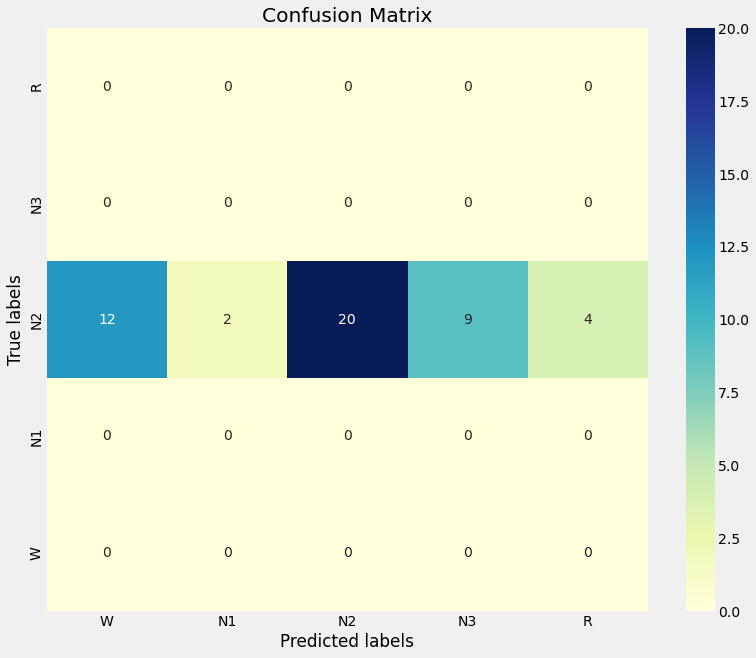

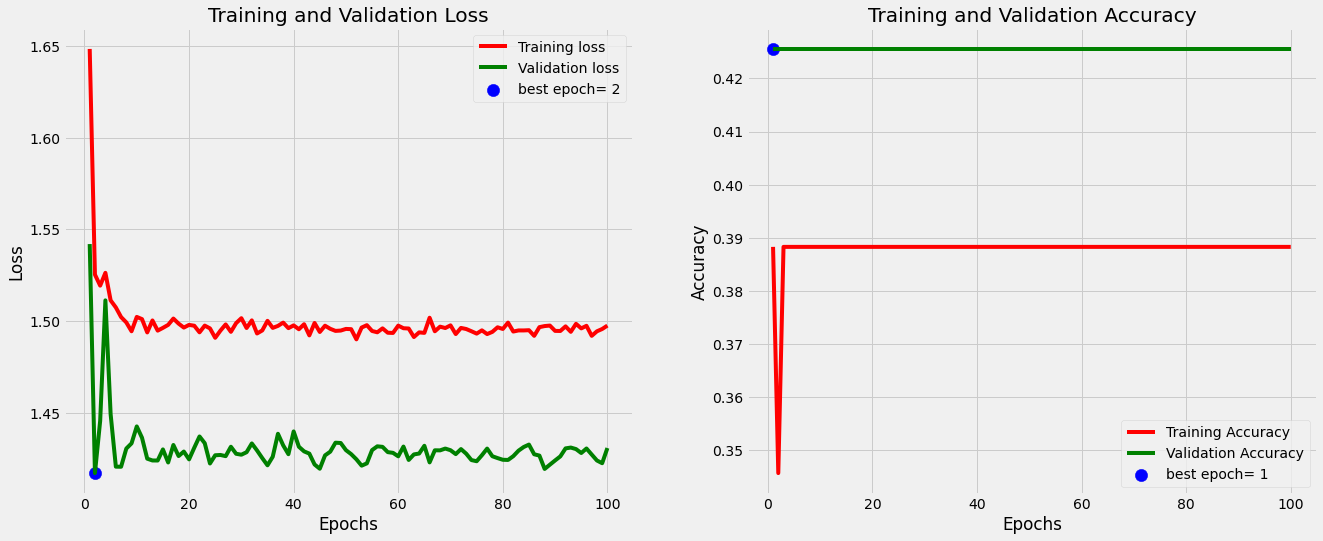

In [42]:
for i in range(len(HIST_LIST)):
    plot_and_f1(TRAINED_MODEL[i], HIST_LIST[i], NAME_LIST[i])